<a href="https://colab.research.google.com/github/raqgmar/tsa4dst/blob/main/01_draft_exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
tfm_path='/content/drive/MyDrive/TFM data/'
H1_code = 'OMNI2_H0_MRG1HR'
M5_code = 'OMNI_HRO2_5MIN'
lookback = 24
lookforward = 12
cols_to_use = ['Bx', 'By_gse', 'Bz_gse', 'By_gsm', 'Bz_gsm', 'P_density', 'AP', 'E_field', 'plasma_T', 'plasma_V']
col_to_predict = "Dst"
hstorms_data = 'historical_storms_gruet2018.csv'
weak_threshold = -30 #1
moderate_threshold = -50 #2
strong_threshold = -100 #3
severe_threshold = -200 #4
great_threshold = -300 #5

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [ ]:
hd = pd.read_csv(tfm_path+H1_code+'.csv', parse_dates=["Datetime"])
md = pd.read_csv(tfm_path+M5_code+'.csv', parse_dates=["Datetime"])
historical_storms = pd.read_csv(tfm_path+hstorms_data)
historical_storms = historical_storms.drop(columns=['Min. Dst (nT)','Unnamed: 0'], axis=1)

In [ ]:
def get_severity(value):
    if weak_threshold < value:
        return 0, '#000000'  # Negro para calma, más discreto
    elif moderate_threshold < value <= weak_threshold:
        return 1, '#00FF00'  # Verde para leve
    elif strong_threshold < value <= moderate_threshold:
        return 2, '#F6BE00'  # Amarillo para moderada
    elif severe_threshold < value <= strong_threshold:
        return 3, '#CE2029'  # Naranja para fuerte
    elif great_threshold < value <= severe_threshold:
        return 4, '#FF0000'  # rojo para severa
    elif value <= great_threshold:
        return 5, '#FF00FF'  # Rojo para muy grave

# Aplicar la función y separar los resultados
hd['severity_info'] = hd['Dst'].apply(get_severity)
hd['severity'] = hd['severity_info'].apply(lambda x: x[0])
hd['severity_color'] = hd['severity_info'].apply(lambda x: x[1])

# Eliminar la columna temporal
hd.drop('severity_info', axis=1, inplace=True)

In [ ]:
# Ordenar los dataframes por fecha
historical_storms = historical_storms.sort_values(by='start')
hd['Datetime']=pd.to_datetime(hd['Datetime'])
historical_storms['start']=pd.to_datetime(historical_storms['start'])
historical_storms['end']=pd.to_datetime(historical_storms['end'])
# Unir basado en la condición de fecha
hd = pd.merge_asof(hd.sort_values('Datetime'), historical_storms, left_on='Datetime', right_on='start', direction='forward')

# Filtrar para asegurar que la fecha de 'hmd' está dentro del intervalo start y end
hd['storm'] = hd.apply(lambda row: row['storm'] if row['Datetime'] <= row['end'] else None, axis=1)

# Limpiar el DataFrame resultante si es necesario
hd = hd.drop(columns=['start', 'end'])

In [ ]:
data = pd.merge(md, hd[["Datetime", "Dst", "severity", "severity_color", "storm"]], on='Datetime', how='left')

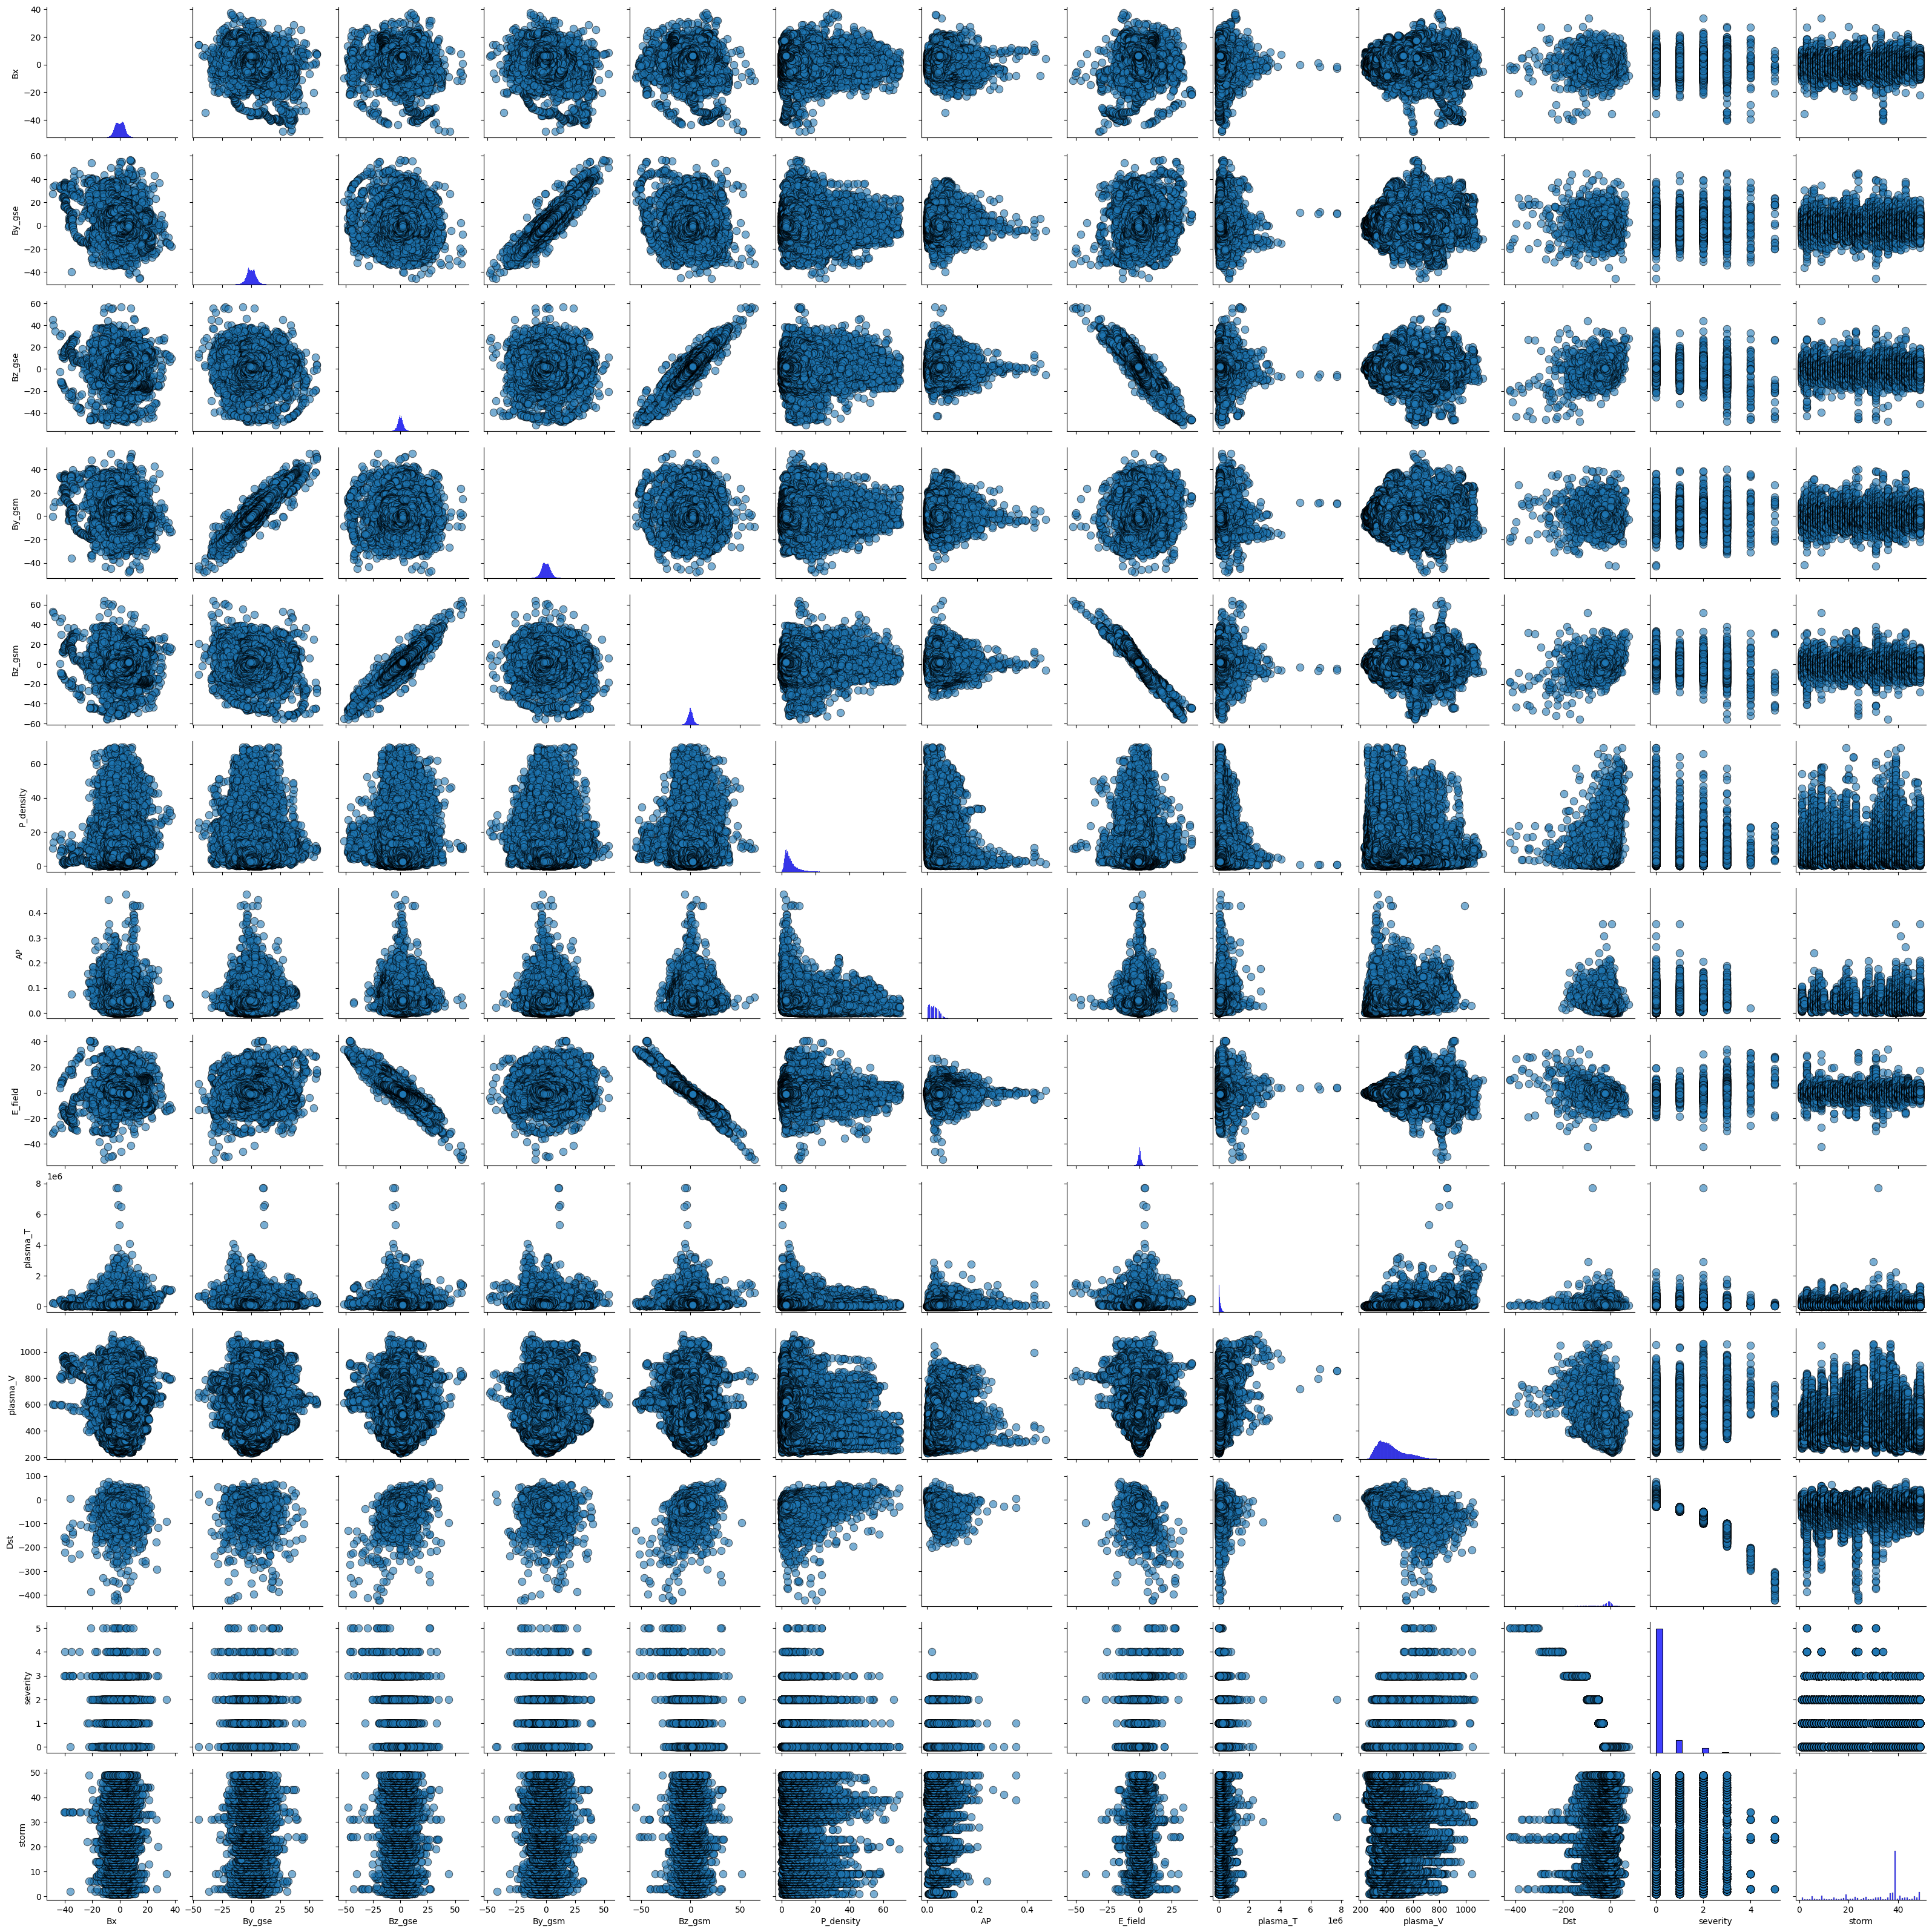

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = data

# Filtrar columnas que no empiezan con 'ID_'
filtered_columns = df.columns[~df.columns.str.startswith('ID_')]
filtered_df = df[filtered_columns]

# Asegurarse de que todas las columnas restantes sean numéricas
numeric_df = filtered_df.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
corr_matrix = numeric_df.corr()

# Crear la matriz de pares
sns.pairplot(numeric_df, kind='scatter', diag_kind='hist', plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'}, diag_kws={'color':'blue'})
plt.show()


## Obtain train and test data.

In [ ]:
def create_window_df_std(df):
  df = df.copy()
  df[col_to_predict] = df[col_to_predict].shift(lookforward)

  x_train, y_train = [], []

  for index in df.dropna(subset=col_to_predict).index:
    if index >= lookback:
      x_train.append(np.asarray(df.iloc[index-lookback:index][cols_to_use].values))
      y_train.append(np.asarray(df.iloc[index][col_to_predict]))
  return np.asarray(x_train), np.asarray(y_train)

In [ ]:
def create_window_df_svr(df):
  df = df.copy()
  df[col_to_predict] = df[col_to_predict].shift(lookforward)
  df = df.StandardScaler()
  x_train, y_train = [], []

  for index in df.dropna(subset=col_to_predict).index:
    if index >= lookback:
      x_train.append(np.asarray(df.iloc[index-lookback:index][cols_to_use].values))
      y_train.append(np.asarray(df.iloc[index][col_to_predict]))
      np.asarray(x_train), np.asarray(y_train)
  return data.reshape(data.shape[0], -1)